<a href="https://colab.research.google.com/github/romankop/Simpsons-Recognition-In-Class-Project/blob/master/Simpsons%20Recognition%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [0]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)


In [0]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


5.3.0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/simpsons4.zip

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!ls train

simpsons_dataset


In [0]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Jan  4 13:47:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

## В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
import random
import numpy as np

random.seed(0)

np.random.seed(0)

torch.manual_seed(0)

torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        #Делаю отдельный трансформер для трейна и отдельный для валидации и теста
        transform_train = transforms.Compose([
        #Добавляю возможных аугментаций, как изменение цветовой гаммы, разворот и поворот по-горизонтали                               
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(45),
            transforms.ToTensor(),   
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_val_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            return transform_val_test(x)
        else:
            if self.mode == 'val':
              x = transform_val_test(x)
            else:
              x = transform_train(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

In [0]:
# transform_train = transforms.Compose([                               
#             transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomRotation(45),
#             transforms.ToTensor(),   
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
#         ])
# datasets.ImageFolder(TRAIN_DIR, transform=transform_train)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [0]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

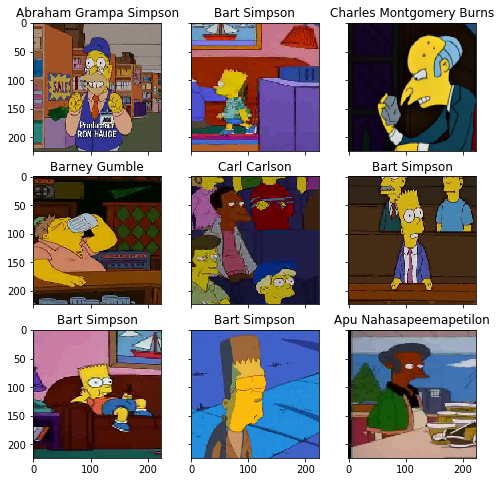

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [0]:
# # Очень простая сеть
# class SimpleCnn(nn.Module):
  
#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #В качестве оптимизатора беру стохастический градиентный спуск с соответствующими learning rate и постоянным вектором 
        opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
        criterion = nn.CrossEntropyLoss()
        # scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[15,25,35], gamma=0.3)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # scheduler.step()
            #сохраняю веса в драйв
            try:
              torch.save(model.state_dict(), "model1_weights_{}.pth".format(epoch)) 
            except:
              pass
            #очищаю кэш
            torch.cuda.empty_cache()
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
n_classes = len(np.unique(train_val_labels))

#Загружаю ResNet-152 с натренированными весами
model_ft = models.resnet152(pretrained=True).to(DEVICE)

# for param in list(model_ft.parameters()):
#     param.requires_grad = False

#Меняю слой классификатора, так как другое количество выходных нейронов
model_ft.fc = nn.Sequential(nn.Linear(2048, n_classes, bias=True)#,
                            # nn.BatchNorm1d(512),
                            # nn.ReLU(inplace=True),
                            # nn.Dropout(0.5),

                            # nn.Linear(512, 256, bias=True),
                            # nn.BatchNorm1d(256),
                            # nn.ReLU(inplace=True),
                            # nn.Dropout(0.5),
                            
                            # nn.Linear(256, n_classes, bias=True)
                            ).to(DEVICE)

print("we will classify :{}".format(n_classes))
# print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:03<00:00, 65.5MB/s]


we will classify :42


Запустим обучение сети.

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [0]:
%%time
history = train(train_dataset, val_dataset, model=model_ft, epochs=20, batch_size=16)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.0267696029121522


epoch:   5%|▌         | 1/20 [20:32<6:30:26, 1232.97s/it]


Epoch 001 train_loss: 1.0268     val_loss 0.2705 train_acc 0.7543 val_acc 0.9315
loss 0.44119989382934305


epoch:  10%|█         | 2/20 [40:55<6:08:58, 1229.93s/it]


Epoch 002 train_loss: 0.4412     val_loss 0.2639 train_acc 0.8858 val_acc 0.9322
loss 0.2644760937509476


epoch:  15%|█▌        | 3/20 [1:01:21<5:48:08, 1228.72s/it]


Epoch 003 train_loss: 0.2645     val_loss 0.1883 train_acc 0.9300 val_acc 0.9541
loss 0.19616699827894582


epoch:  20%|██        | 4/20 [1:21:39<5:26:49, 1225.57s/it]


Epoch 004 train_loss: 0.1962     val_loss 0.1763 train_acc 0.9491 val_acc 0.9567
loss 0.1576196787968997


epoch:  25%|██▌       | 5/20 [1:42:00<5:06:01, 1224.09s/it]


Epoch 005 train_loss: 0.1576     val_loss 0.1797 train_acc 0.9587 val_acc 0.9565
loss 0.12671504693373653


epoch:  30%|███       | 6/20 [2:02:22<4:45:27, 1223.36s/it]


Epoch 006 train_loss: 0.1267     val_loss 0.1632 train_acc 0.9666 val_acc 0.9619
loss 0.11405862715965524


epoch:  35%|███▌      | 7/20 [2:22:42<4:24:53, 1222.58s/it]


Epoch 007 train_loss: 0.1141     val_loss 0.1354 train_acc 0.9697 val_acc 0.9688
loss 0.08929142645745605


epoch:  40%|████      | 8/20 [2:43:02<4:04:19, 1221.61s/it]


Epoch 008 train_loss: 0.0893     val_loss 0.1804 train_acc 0.9751 val_acc 0.9588
loss 0.08541662848370804


epoch:  45%|████▌     | 9/20 [3:03:23<3:43:55, 1221.44s/it]


Epoch 009 train_loss: 0.0854     val_loss 0.1094 train_acc 0.9767 val_acc 0.9768
loss 0.08018474458594586


epoch:  50%|█████     | 10/20 [3:23:47<3:23:42, 1222.25s/it]


Epoch 010 train_loss: 0.0802     val_loss 0.1174 train_acc 0.9777 val_acc 0.9747
loss 0.07021230754125452


epoch:  55%|█████▌    | 11/20 [3:44:12<3:03:27, 1223.09s/it]


Epoch 011 train_loss: 0.0702     val_loss 0.1162 train_acc 0.9807 val_acc 0.9731
loss 0.06570272109482257


epoch:  60%|██████    | 12/20 [4:04:30<2:42:51, 1221.44s/it]


Epoch 012 train_loss: 0.0657     val_loss 0.1516 train_acc 0.9808 val_acc 0.9653
loss 0.061456388331497684


epoch:  65%|██████▌   | 13/20 [4:24:46<2:22:20, 1220.01s/it]


Epoch 013 train_loss: 0.0615     val_loss 0.1147 train_acc 0.9832 val_acc 0.9721
loss 0.049126317718531584


epoch:  70%|███████   | 14/20 [4:45:05<2:01:58, 1219.74s/it]


Epoch 014 train_loss: 0.0491     val_loss 0.0975 train_acc 0.9876 val_acc 0.9804
loss 0.04107882873539102


epoch:  75%|███████▌  | 15/20 [5:05:22<1:41:34, 1218.84s/it]


Epoch 015 train_loss: 0.0411     val_loss 0.1088 train_acc 0.9883 val_acc 0.9752
loss 0.04415722296181447


epoch:  80%|████████  | 16/20 [5:25:43<1:21:17, 1219.28s/it]


Epoch 016 train_loss: 0.0442     val_loss 0.0957 train_acc 0.9885 val_acc 0.9803
loss 0.040063076961671405


epoch:  85%|████████▌ | 17/20 [5:46:06<1:01:01, 1220.53s/it]


Epoch 017 train_loss: 0.0401     val_loss 0.1402 train_acc 0.9880 val_acc 0.9712
loss 0.04194294214492697


epoch:  90%|█████████ | 18/20 [6:06:28<40:42, 1221.03s/it]


Epoch 018 train_loss: 0.0419     val_loss 0.1099 train_acc 0.9891 val_acc 0.9804
loss 0.035998131287898916


epoch:  95%|█████████▌| 19/20 [6:26:54<20:22, 1222.52s/it]


Epoch 019 train_loss: 0.0360     val_loss 0.1186 train_acc 0.9900 val_acc 0.9791
loss 0.03752221003945619


epoch: 100%|██████████| 20/20 [6:47:33<00:00, 1227.30s/it]


Epoch 020 train_loss: 0.0375     val_loss 0.0960 train_acc 0.9902 val_acc 0.9791
CPU times: user 4h 24min 27s, sys: 2h 21min 51s, total: 6h 46min 19s
Wall time: 6h 47min 33s


Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

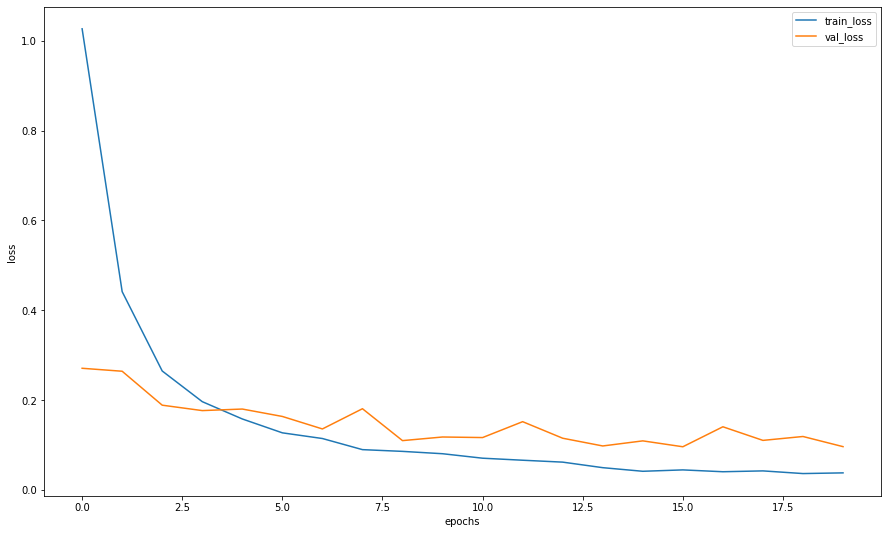

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [0]:
#Загружаю понравившиеся веса в модель (веса на эпохе, где были хорошие значения на валидационном сете)
model_ft.load_state_dict(torch.load("model1_weights_17.pth"))


<All keys matched successfully>

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_ft, ex_img.unsqueeze(0))

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_ft, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [0]:
y_pred

array([2, 2, 4, 4, 0, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0])

In [0]:
from sklearn.metrics import f1_score

for t in ['micro', 'macro', 'weighted']:

  print(f1_score(actual_labels, y_pred, average=t), '\n', end='')


1.0 
1.0 
1.0 


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

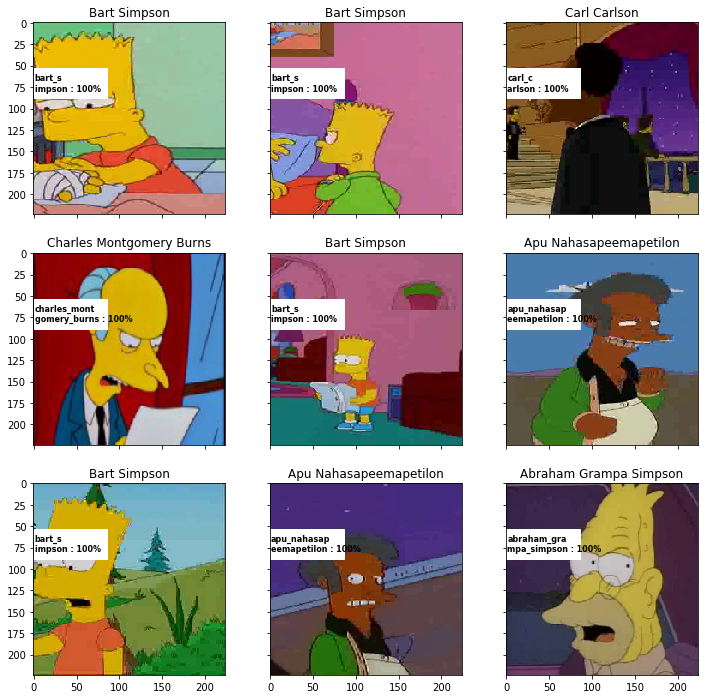

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [0]:
! ls 

characters_illustration.png  model1_weights_15.pth  model1_weights_6.pth
drive			     model1_weights_16.pth  model1_weights_7.pth
gdrive			     model1_weights_17.pth  model1_weights_8.pth
label_encoder.pkl	     model1_weights_18.pth  model1_weights_9.pth
model1_weights_0.pth	     model1_weights_19.pth  resnet_epoch16.csv
model1_weights_10.pth	     model1_weights_1.pth   resnet_epoch20.csv
model1_weights_11.pth	     model1_weights_2.pth   sample_data
model1_weights_12.pth	     model1_weights_3.pth   sample_submission.csv
model1_weights_13.pth	     model1_weights_4.pth   testset
model1_weights_14.pth	     model1_weights_5.pth   train


In [0]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds}) 
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [0]:
my_submit.to_csv('resnet_epoch18.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
